# Description
I will use several deep learning models for my time series predictions. 
* LSTM
* Transformer
* dialated CNN

In all cases I will include daily snowfall as an exogenous variable.

## Environment
For $ reasons I will use Colab

In [1]:
# get colab status
try:
    import google.colab
    IN_COLAB = True
    %tensorflow_version 2.x
except:
    IN_COLAB = False

In [2]:
# data wrangling
import numpy as np
import pandas as pd
import os.path

# viz
import altair as alt
import matplotlib.pyplot as plt
%matplotlib inline
from vapeplot import vapeplot
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

In [3]:
# local code with hack to avoid cloing full repo each time colab is run
if IN_COLAB:
    projectcode = r"https://github.com/chrisoyer/ski-snow-modeling/blob/master/src/analysis/project_utils/project_utils.py"
    ! wget $projectcode
from project_utils.project_utils import *

In [4]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import RootMeanSquaredError as rmse

# Parameters

In [5]:
alt.renderers.enable(embed_options={'theme': 'vox'})
alt.data_transformers.disable_max_rows()
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')
plt.rc('figure', figsize=(11.0, 7.0))
batch_size = 15
logs_path = "./logs/visualize_graph"

lookback = 30  # days prior to use for prediction

# Plotting Functions

In [6]:
def hist_plotter(hist):
    """plots train and validation scores by epoch
    hist: TF history object
    """
    metrics = [m for m in hist if 'loss' not in m and 'val' not in m]
    fig, ax = plt.subplots(nrows=len(metrics), ncols=1, sharex=True)
    fig.patch.set_facecolor('whitesmoke')
    
    for i, metric in enumerate(metrics):
        train_metric = (pd.DataFrame(enumerate(hist[metric], 1))
                        .rename(columns={0:'epoch', 1:'value'}))
        ax[i].plot(train_metric.epoch, train_metric.value, label=f"Train")
        val_metric = (pd.DataFrame(enumerate(hist[f"val_{metric}"], 1))
                       .rename(columns={0:'epoch', 1:'value'}))
        ax[i].plot(val_metric.epoch, val_metric.value, label="Validation")
        ax[i].set_title(f"{metric}")
    plt.legend(loc='upper right')
    fig.suptitle('Training and Validation Metrics')
    plt.xlabel('Epochs')
    plt.show()

# Load Data

In [7]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/gdrive')
    os.chdir(r'/content/gdrive/My Drive/data_sci/colab_datasets/ski/')
    all_data_path = r'./data/snow_data_clean.parquet'
    mirrored_strategy = tf.distribute.MirroredStrategy()
else:
    all_data_path = r'../../data/snow_data_clean.parquet'
!pwd

/c/Users/User/Documents/GitHub/ski-snow-modeling/src/analysis


In [8]:
snow_df = pd.read_parquet(all_data_path)

### Reshape for TF input
Shape should match (__samples__, __time steps__, __features__)

In [9]:
def data_slim(source=snow_df, station=None, region=None):
    """filters data for station OR region, relevant features, and returns np"""
    if station:
        source = source.query('station==@station')
    if region:
        source = source.query('region==@region')

    data_arr = (source
                .reset_index()
                [['base', 'dayofyr', 'snowfall']]
                .to_numpy()
                )
    return data_arr

In [10]:
# scale data
def scaler(X):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(X)
    scaled_X = scaler.transform(X)

    # invert transform
    inverted_X = scaler.inverse_transform(scaled_X)
    return scaled_X#, inverted_X

In [11]:
copper = data_slim(station="Copper Mountain")

copper_scaled = scaler(copper)

In [12]:
def data_split(data=None, test_frac=.2, lookback=lookback, batch_size=batch_size):
    """split into train and test sets
    Params:
        data: endogenous should be first col
        test_size: fraction of data for test
    returns: (training data generator, test data generator)
    """
    data_rows = data.shape[0]
    test_size = int(data_rows * test_frac)
    train_size = data_rows - test_size
    train, test = data[:train_size, :], data[train_size:, :]
    gen_params = {'length': lookback,  # prior samples used for prediction
                  'sampling_rate': 1, 'stride': 1,
                  'batch_size': batch_size}
    train_data_gen = sequence.TimeseriesGenerator(data=train,
                                                  targets=train[:, 0],
                                                  **gen_params)
    test_data_gen = sequence.TimeseriesGenerator(data=test,
                                                 targets=test[:, 0],
                                                 **gen_params)
    return train_data_gen, test_data_gen


Xy_train, Xy_val = data_split(data=copper_scaled)

# Timeseries Modeling

The evolution of snow base depth over time depends (not 1:1; a foot of powder is only a few inches of packed powder) on new snowfall and melting of old snow. I will start by modeling as a simple timeseries, and then include new snowfall as a predictor variable.

## Modeling Setup
I will use supersetting crossvalidation (walk-forward CV) since this is a time series problem.

# TF LSTM models
 

In [33]:
def make_lstm(neurons=None, layers=None, batch_size=None, x_shape=None, lookback=lookback):
    """
    Parameters:
        neurons: width of layers, eg (4,5,6) implies first hidden layer has 4
            neuron, 2nd layer has 5, third layer has 6
        batch size: ...
        x_shape: (rows, features)
    Returns: unfitted model
    """
    input_shape = (lookback, x_shape[1])
    xlayer = inputs = Input(shape=input_shape, batch_size=batch_size)
    for layer in range(layers):
        lstm_kwargs = dict(units=neurons, batch_input_shape=input_shape,
                           stateful=True, dropout=0.2, recurrent_dropout=0.2)
        if layer == layers-1:
            lstm_kwargs = {**lstm_kwargs, 'return_sequences': True}
        xlayer = LSTM(**lstm_kwargs)(xlayer)
    outputs = Dense(1)(xlayer)
    model = Model(inputs=inputs, outputs=outputs)
    metrics = ['mean_absolute_error', 'mean_squared_error']
    model.compile(loss="mse", metrics=metrics,
                  optimizer='adam')
    return model


def fit_model(model, X, X_val, batch_size, n_epoch):
    """runs the training; returns model and history"""
    history = model.fit(X, validation_data=X_val,
                        epochs=n_epoch, batch_size=batch_size,
                        shuffle=False, callbacks=[],
                        verbose=1)
    return model, history

# Vanilla LSTM Model
### 1 layer

In [34]:
lstm_100x1 = make_lstm(neurons=100, layers=1,
                       batch_size=batch_size, x_shape=copper_scaled.shape)
lstm_100x1.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(15, 30, 3)]             0         
_________________________________________________________________
lstm_7 (LSTM)                (15, 30, 100)             41600     
_________________________________________________________________
dense_4 (Dense)              (15, 30, 1)               101       
Total params: 41,701
Trainable params: 41,701
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lstm_100x1, lstm_100x1_hst = fit_model(model=lstm_100x1, 
                                       X=Xy_train, 
                                       X_val=Xy_val,
                                       batch_size=batch_size, n_epoch=20)

Epoch 1/20
154/154 [==============================] - 6s 41ms/step - loss: 0.1107 - mean_absolute_error: 0.2617 - mean_squared_error: 0.1107 - val_loss: 0.0385 - val_mean_absolute_error: 0.1531 - val_mean_squared_error: 0.0385
Epoch 2/20
154/154 [==============================] - 6s 36ms/step - loss: 0.0502 - mean_absolute_error: 0.1673 - mean_squared_error: 0.0502 - val_loss: 0.0345 - val_mean_absolute_error: 0.1465 - val_mean_squared_error: 0.0345
Epoch 3/20
154/154 [==============================] - 5s 35ms/step - loss: 0.0470 - mean_absolute_error: 0.1595 - mean_squared_error: 0.0470 - val_loss: 0.0290 - val_mean_absolute_error: 0.1308 - val_mean_squared_error: 0.0290
Epoch 4/20
154/154 [==============================] - 5s 34ms/step - loss: 0.0443 - mean_absolute_error: 0.1533 - mean_squared_error: 0.0443 - val_loss: 0.0287 - val_mean_absolute_error: 0.1296 - val_mean_squared_error: 0.0287
Epoch 5/20
154/154 [==============================] - 5s 33ms/step - loss: 0.0430 - mean_abs

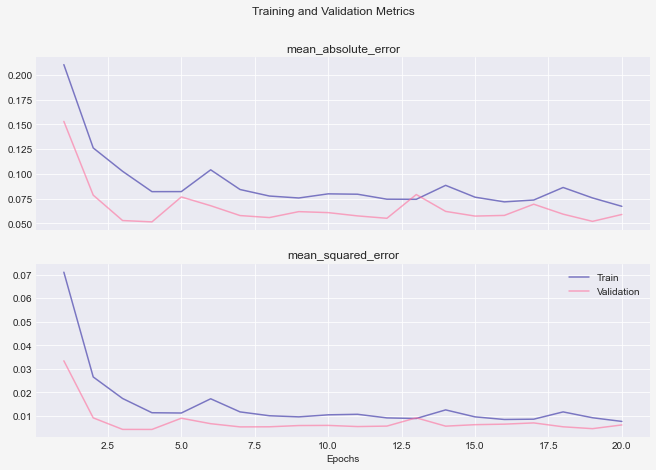

In [16]:
hist_plotter(lstm_100x1_hst.history)

### 2 Layers

In [ ]:
lstm_100x2 = make_lstm(neurons=100, layers=2,
                       batch_size=batch_size, x_shape=copper_scaled.shape)
lstm_100x2.summary()

In [ ]:
lstm_100x2, lstm_100x2_hst = fit_model(model=lstm_100x2, 
                                       X=Xy_train, 
                                       X_val=Xy_val,
                                       batch_size=batch_size, n_epoch=20)

# Compare Models